# Check traces

Highlights:  
- I validated that trace loading is correct with two methods: 
    - 1) a simulation data (from one BlueConfig) are chunked into 30 pieces
    - 2) the same simulation data (from one BlueConfig) are already preprocessed and stored into one `_rec` and `_true_spike` files

Question: 

- How were `_rec` and `.._true_spikes` files generated?

In [52]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe
from spikeinterface.comparison import GroundTruthStudy
import shutil

pd.set_option('display.max_colwidth', None)

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"

os.chdir(PROJ_PATH)
from src.pipelines.simulation.dataeng.loading import load_params_for_one_simulation_piece
from src.pipelines.simulation.sorting import ground_truth
from src.pipelines.simulation.dataeng import loading_raw_recording
from src.pipelines.simulation.preprocessing import silico_preprocess

from src.nodes.utils import get_config


# SETUP PARAMETERS
# the date of the simulation to run
SIMULATION_DATE = "2022_10_28"

# traces parameters
CHANNEL_ID = np.arange(64,80).tolist()
N_SAMPLE = 80000                    # plot x-max (number of samples)
MIN_MAX_AMPLITUDE = [-400, 150]     # plot y-max 

# spiking parameters
MIN_SPIKE = 10


# SETUP CONFIG
print("CONFIG:\n")
config = get_config(SIMULATION_DATE)
pp.pprint(config["dataset_conf"])
pp.pprint(config["param_conf"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CONFIG:

{'input': {'one_piece': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0/BlueConfig',
           'simulated_traces_and_spikes': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128_0/results/',
           'simulation_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0',
           'waveform_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_real_wfs',
           'weightspath': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/coeffsreyespuerta.h5'},
 'output': {'ground_truth_sorting_object': {'write_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_true_spikes'},
            'out': '/gpfs/bbp.cscs.ch/project/proj68

In [56]:
# define custom functions
def get_waveform_extractor_and_ground_truth(rec0, gt_sorting0, study_folder:str, min_spike:int=10):
    
    # remove units with less than 10 spikes
    gt_dict = gt_sorting0.get_total_num_spikes()
    rare_gids = list(dict((k, v) for k, v in gt_dict.items() if v <= min_spike).keys())
    gt_sorting0 = gt_sorting0.remove_units(rare_gids)
    print("report gids with less than 10 spikes:", rare_gids[:5])
    print("report curated units: ", gt_sorting0)

    # create study object
    gt_dict = {
        'rec0': (rec0, gt_sorting0),
    }

    # overwrite existing data
    shutil.rmtree(study_folder, ignore_errors = True)
    study = GroundTruthStudy.create(study_folder, gt_dict)

    # get waveforms
    study.compute_waveforms(rec0, ms_before = 2, ms_after = 2)
    waveform_extractor = study.get_waveform_extractor(rec0)
    GroundTruth = study.get_ground_truth(rec0)
    return {
        "waveform_extractor" : waveform_extractor, 
        "GroundTruth" : GroundTruth
        }

def plot_unit_waveform(waveform_extractor, unit_id:np.array):

    # plot 
    colors = ['Olive', 'Teal', 'Fuchsia']

    # get channels where spike amplitude is maximal
    max_chids = spost.get_template_extremum_channel(waveform_extractor, peak_sign='neg')

    # plot each cell waveform extracted from its best channel
    for i, unit_id in enumerate(unit_id):

        # get cell waveforms
        wf = waveform_extractor.get_waveforms(unit_id)
    
        # get best channel index in array
        idx = int(max_chids[unit_id]) - 64

        # plot waveform instances
        plt.plot(wf[:, :, idx-1].T, color=colors[1], lw=0.3)
    
        # plot average waveform
        tmp = waveform_extractor.get_template(unit_id)
        plt.plot(tmp[:,idx-1], color = colors[2])
        plt.title(f"Cell id: {unit_id} on Channel {max_chids[unit_id]}")
        plt.show()


# Compare two extraction methods

## Custom

Obs:

- 4 sec trace (80000 sampling steps / 20000 Hz sampling frequency)

In [4]:
# get preprocessed traces
preprocessed_traces = silico_preprocess.run(config["dataset_conf"], config["param_conf"])

write_binary_recording with n_jobs = 1 and chunk_size = None


## From REC file method

Both methods load the same traces.

In [31]:
# set paths
outpath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/'
name = 'Hex0_4s_reyes128'
simpath = '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0'
out = outpath + name +'/' + name
outrec = out + '_rec'          # recording
outsort = out + '_true_spikes' # sorted spikes
STUDY_FOLDER = out + '_study'

In [66]:
type(rec0)
type(gt_sorting0)

spikeinterface.core.unitsselectionsorting.UnitsSelectionSorting

In [ ]:
# read recording dataset and sorted dataset
rec = si.load_extractor(outrec)
gt_sorting0 = si.load_extractor(outsort)

In [8]:
# select a set of channel traces
rec0 = rec.channel_slice(channel_ids=CHANNEL_ID)
print("describe selected channels: ", rec0)
print("get channel ids: ", rec0.get_channel_ids())

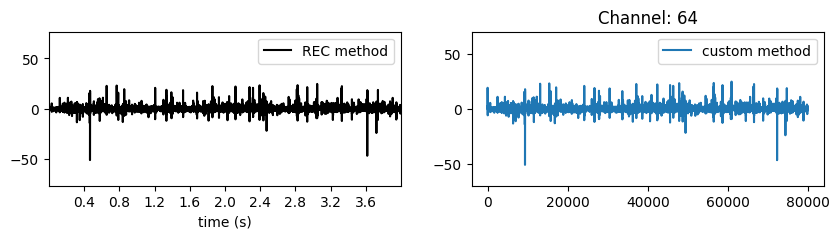

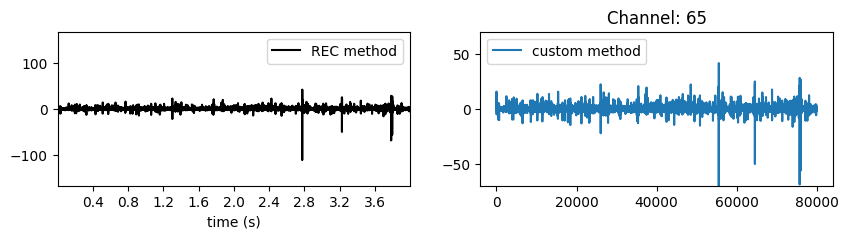

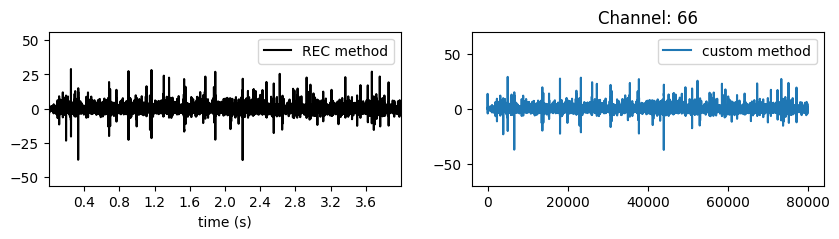

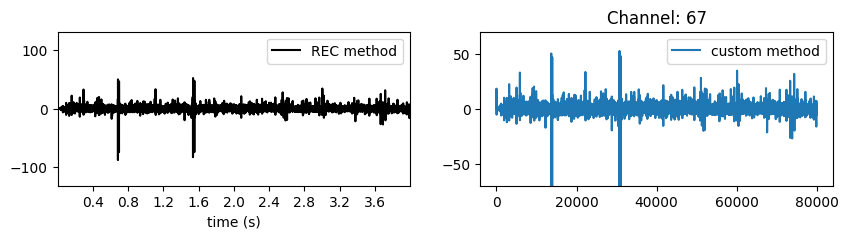

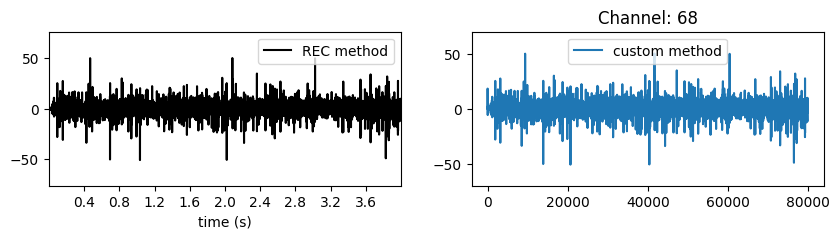

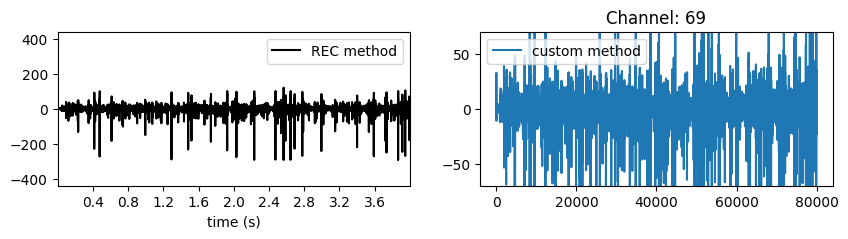

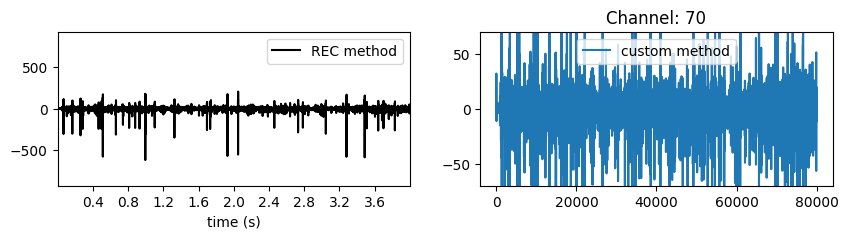

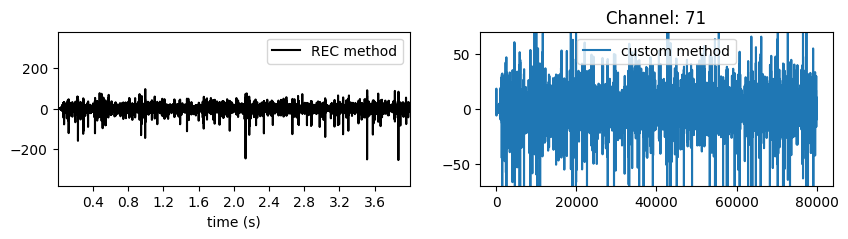

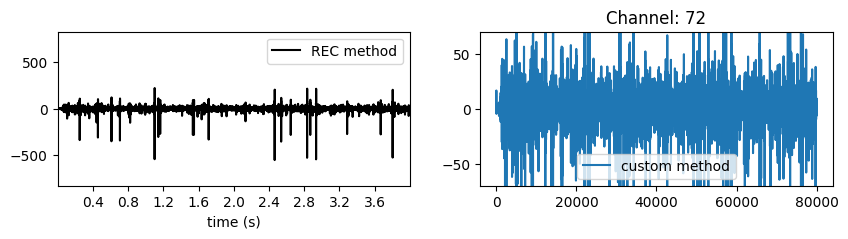

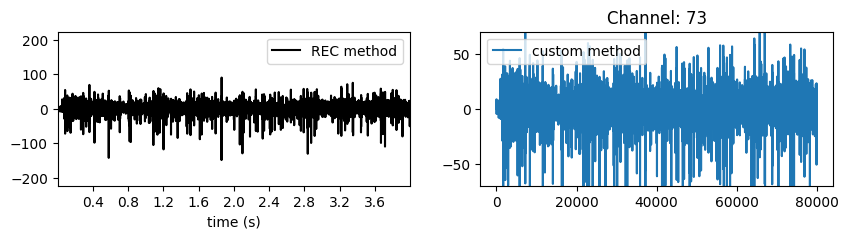

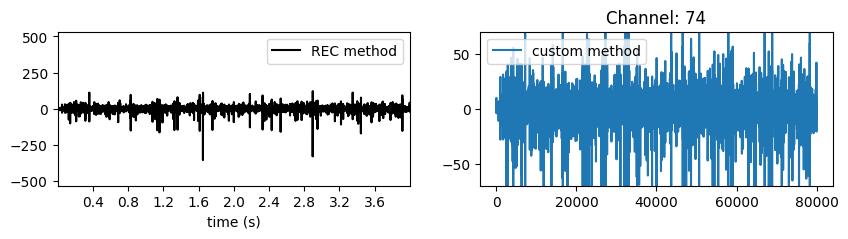

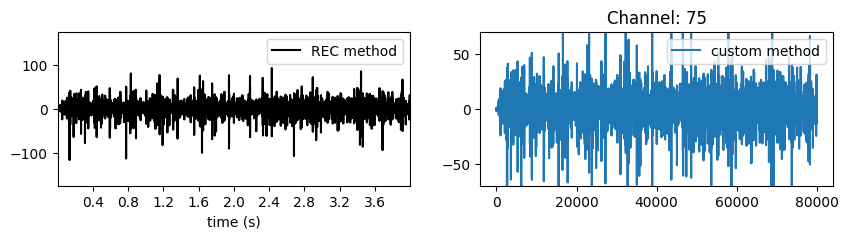

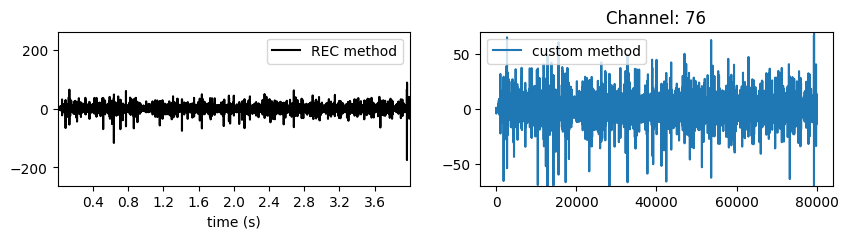

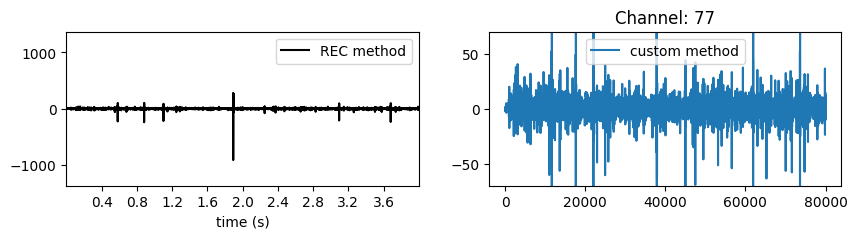

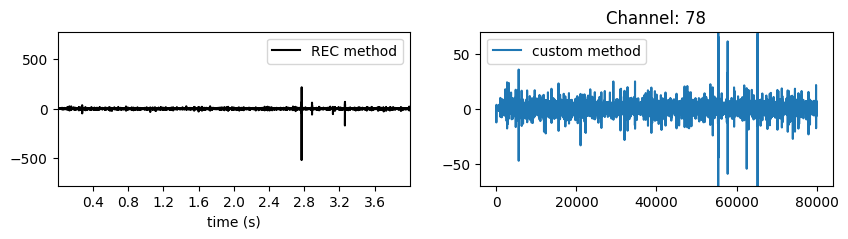

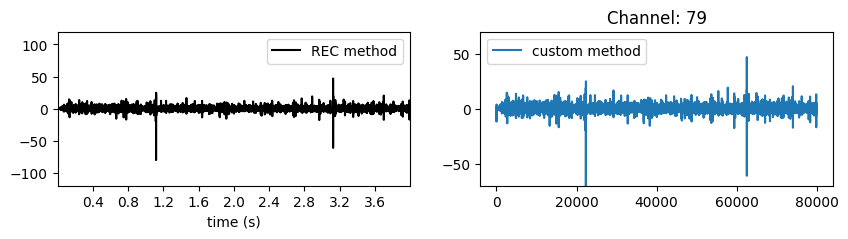

In [60]:
# plot and compare
for c_i in range(len(CHANNEL_ID)):
    
    fig, axes = plt.subplots(1,2, figsize=(10,2))
    
    # with rec 
    sw.plot_timeseries(rec0, channel_ids = [CHANNEL_ID[c_i]], time_range = (0,4), ax=axes[0]);
    axes[0].legend(["REC method"])

    # custom
    trace = preprocessed_traces.get_traces()[:, CHANNEL_ID[c_i]]
    axes[1].plot(trace);
    axes[1].set_ylim([-70, 70])
    axes[1].legend(["custom method"])

    plt.title(f"Channel: {CHANNEL_ID[c_i]}");

    # legend
    plt.show()

# Inspect waveforms

report gids with less than 10 spikes: []
report curated units:  UnitsSelectionSorting: 26 units - 1 segments - 20.0kHz
write_binary_recording with n_jobs = 1 and chunk_size = None


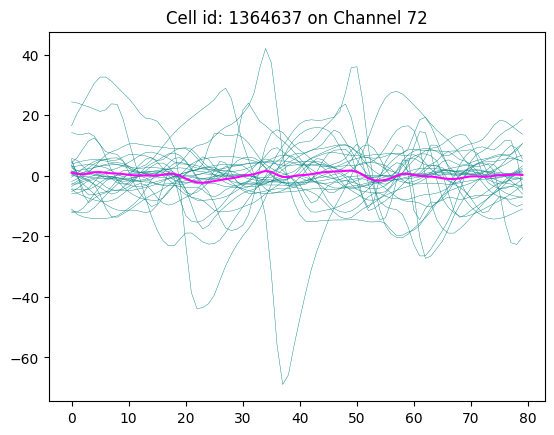

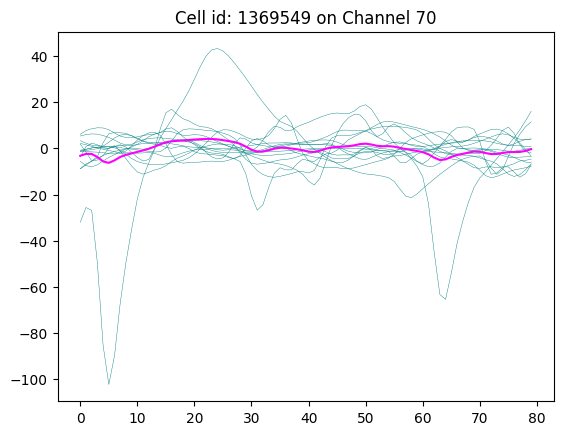

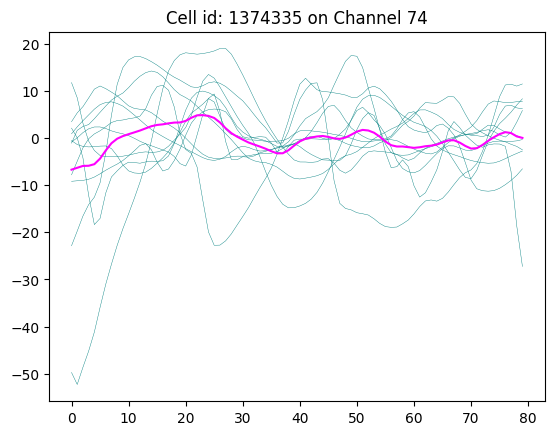

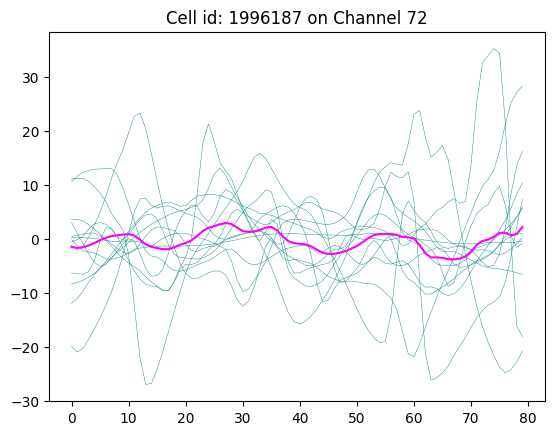

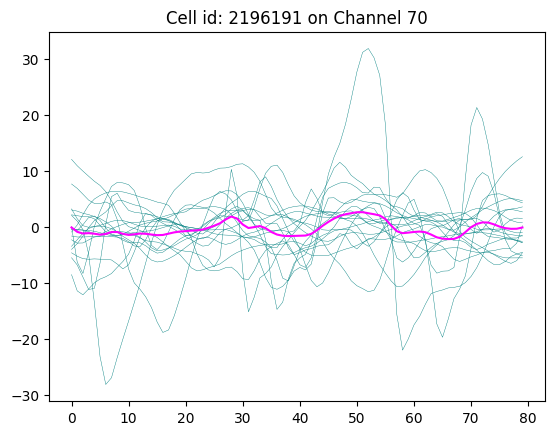

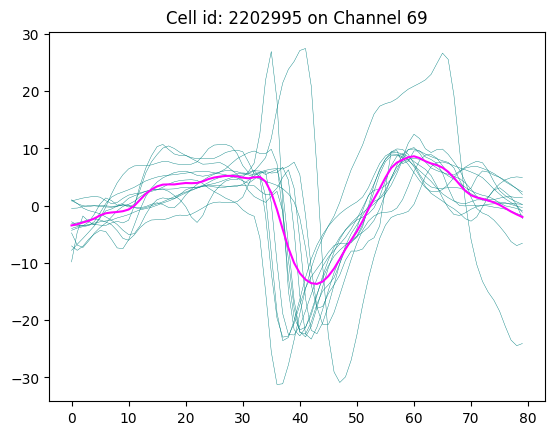

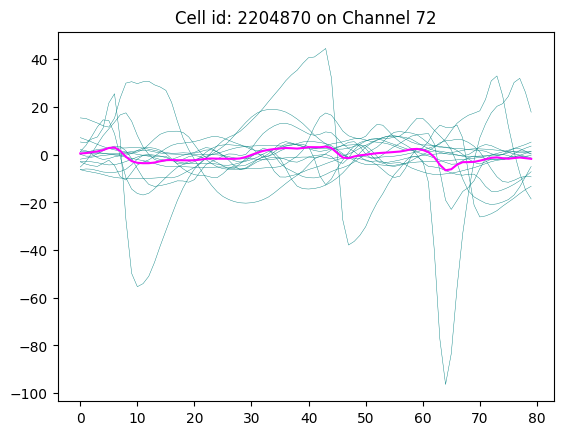

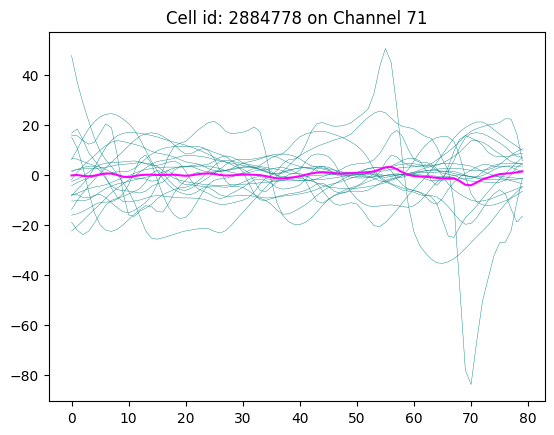

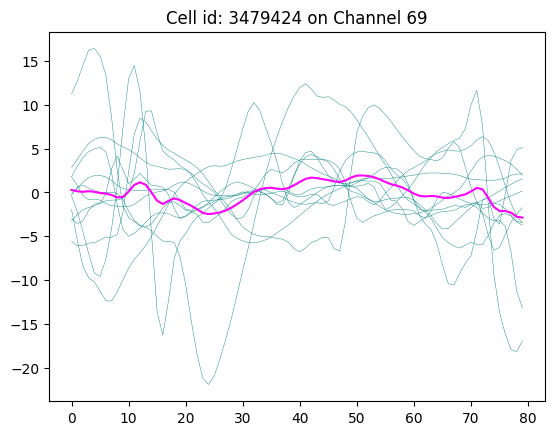

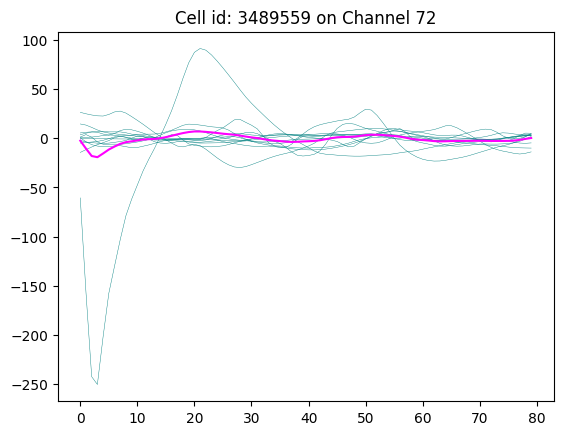

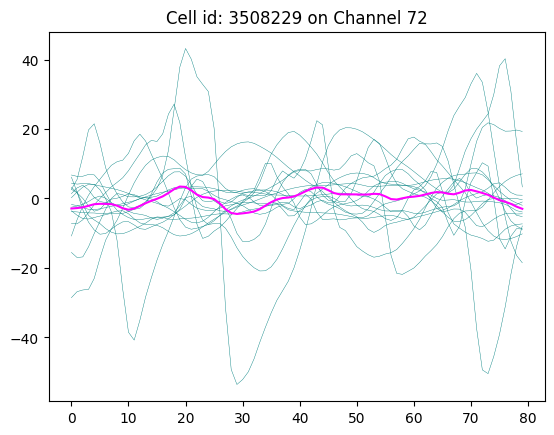

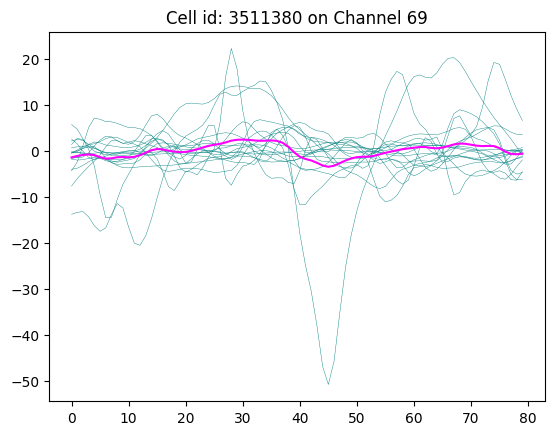

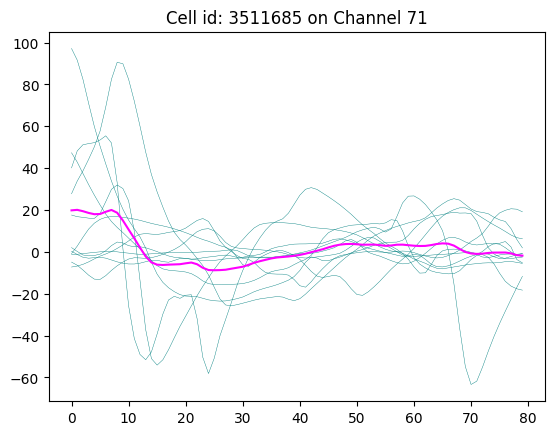

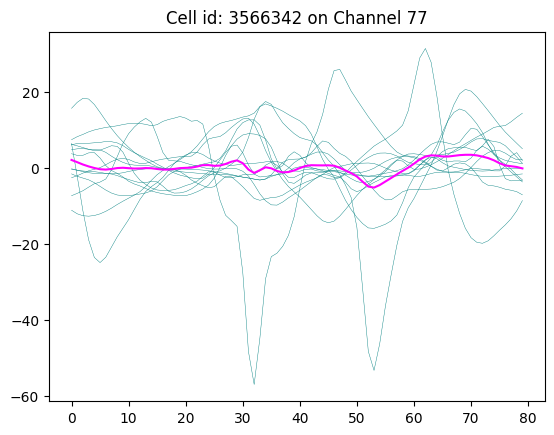

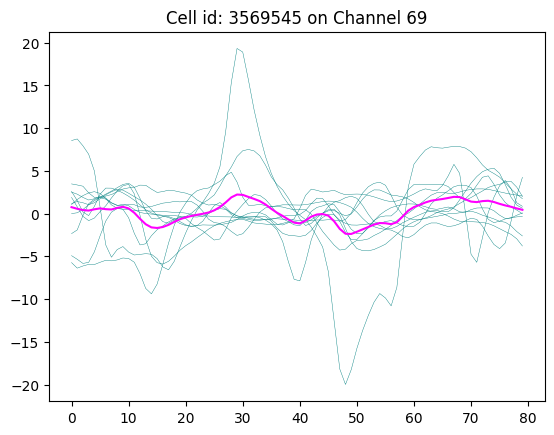

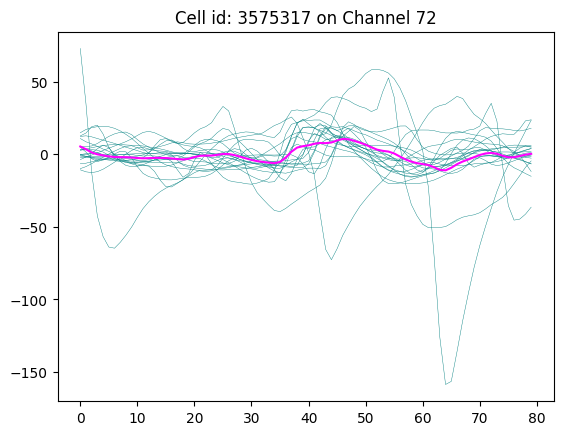

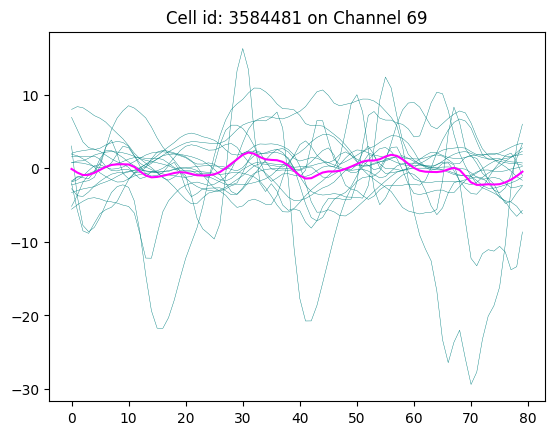

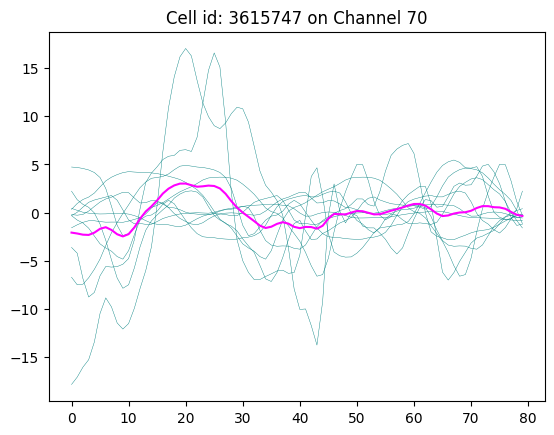

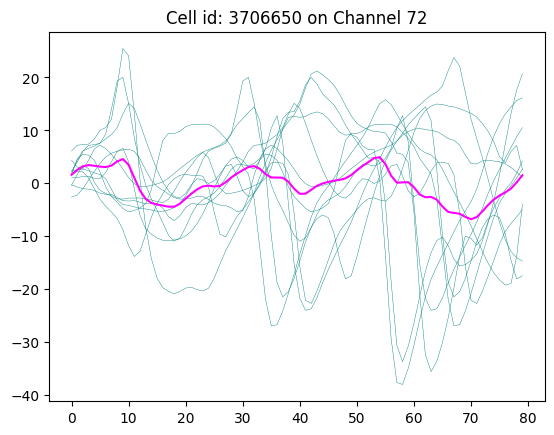

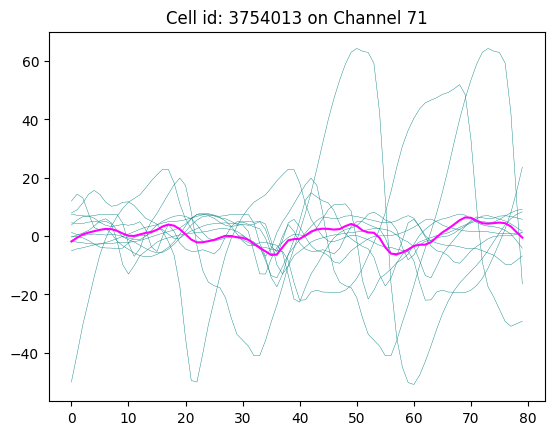

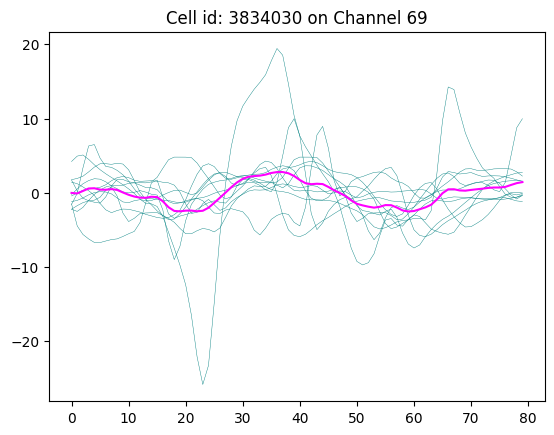

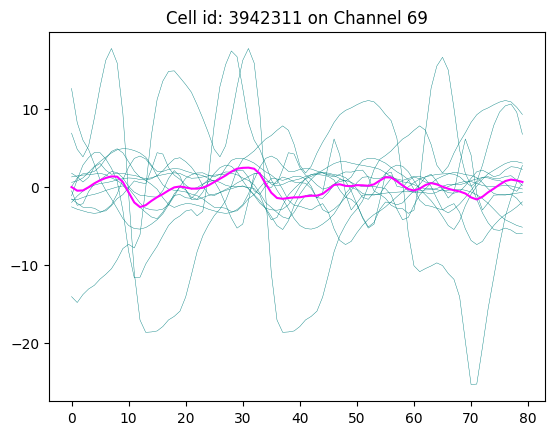

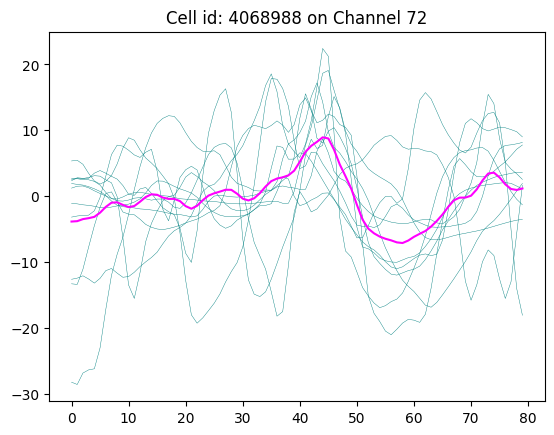

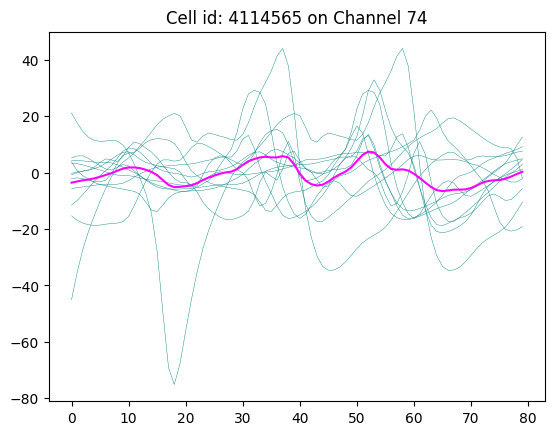

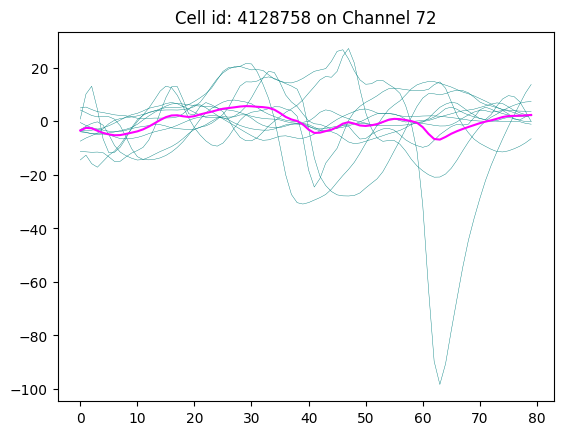

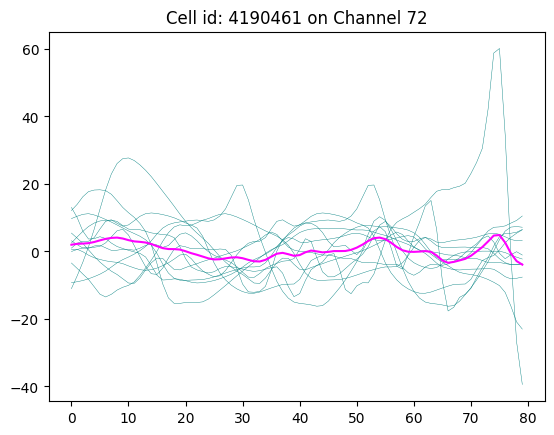

In [57]:
# get data
out = get_waveform_extractor_and_ground_truth(rec0, gt_sorting0, study_folder=STUDY_FOLDER, min_spike=MIN_SPIKE)

# plot 
plot_unit_waveform(waveform_extractor = out["waveform_extractor"], unit_id = out["GroundTruth"].unit_ids)